We test the example whose energy function is shown by 
\begin{aligned}
E(x,y)=x^{4}-1.5x^{2}y^{2}+y^{4}-2y^{3}+y^{2}+x^{2}y-2x^{2}.
\end{aligned}

First, we add the path of the `soluscape-1.0` directory to the system path.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'soluscape-1.0')))

Then, we import the main class.

In [2]:
from soluscape import Landscape
import numpy as np
# import packages needed

We define the energy function.

In [3]:
energyfunction = 'x1**4 -1.5*x1**2*x2**2+ x2**4 - 2*x2**3 + x2**2 + x1**2*x2 - 2*x1**2' 
# given energy function

In [4]:
# parameter initialization
x0 = np.array([0.1, 0.1]) # initial point
dt = 1e-2 # time step
k = 2 # the maximum index of saddle point
acceme = 'none'
maxiter = 10000 # max iter

We initialize the solver and run it.

In [5]:
MyLandscape = Landscape(MaxIndex=k, AutoGrad=True, EnergyFunction=energyfunction, 
						EigenMethod='euler', EigenMaxIter=1, InitialPoint=x0, 
						TimeStep=dt, Acceleration=acceme, MaxIter=maxiter, 
						EigenCombination='all', PerturbationNumber=1, 
						PerturbationRadius=1e-2, Verbose=True, ReportInterval=100)
# Instantiation
MyLandscape.Run()
# Calculate

HiSD Solver Configuration:
------------------------------
[HiSD] Current parameters (initialized):
[Config Sync] `Dim` parameter auto-adjusted to 2 based on `InitialPoint` dimensionality.
Parameter `NumericalGrad` not specified - using default value False.
Using `EnergyFunction` instead of `Grad` - enabling auto-differentiation mode.
Parameter `Momentum` not specified - using default value 0.0.
Parameter `BBStep` not specified - using default value False.
Parameter `DimerLength` not specified - using default value 1e-05.
Parameter `Tolerance` not specified - using default value 1e-06.
Parameter `NesterovChoice` not specified - using default value 1.
Parameter `SearchArea` not specified - using default value 1000.0.
Parameter `NesterovRestart` not specified - using default value None.
Parameter `HessianDimerLength` not specified - using default value 1e-05.
Parameter `EigenStepSize` not specified - using default value 1e-05.
Parameter `ExactHessian` not specified - using default value F

We draw the search trajectory.

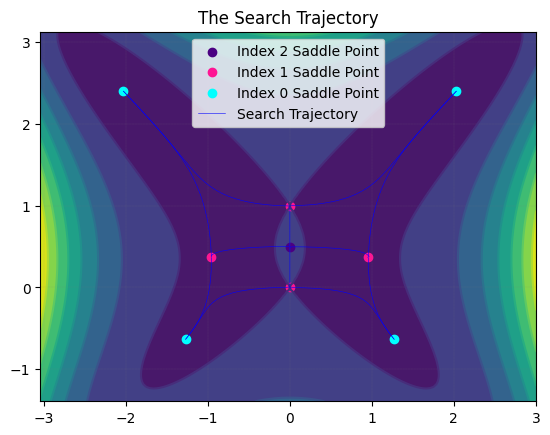

In [6]:
MyLandscape.DrawTrajectory(ContourGridNum=100, ContourGridOut=25, DetailedTraj=True)
# Draw the search path.

We can also draw the solution landscape and save the data.

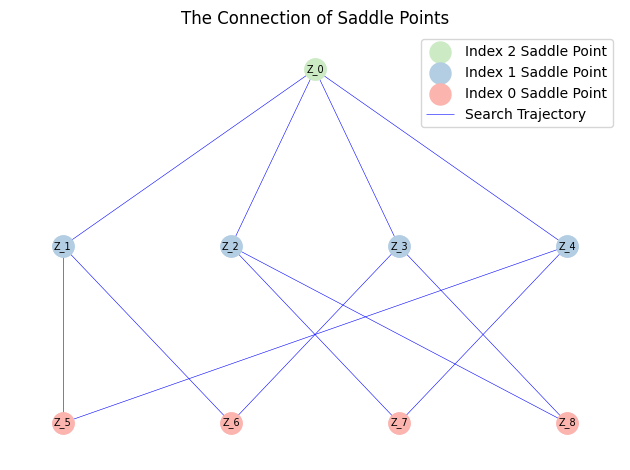

In [8]:
MyLandscape.DrawConnection()
MyLandscape.Save('output\Ex_Butterfly')
# Save the data

Then, we save the search trajectory.

In [9]:
import json

detail = MyLandscape.DetailRecord
output = {
			"Start ID": [row[1] for row in detail],
			"End ID": [row[0] for row in detail],
			"Path Positions": [row[2].tolist() for row in detail],
			"Path Times": [row[3].tolist() for row in detail]
		}

with open('output\Ex_ButterflyDetail.json', 'w') as f:
	json.dump(output, f)

Moreover, we can do more post-processing using the output data. We will generate the motiion graph of search trajectory as an example.

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Colormap

def animateSL(fig: plt.Figure,
			  ax: plt.Axes,
			  saddleinfo: dict,
			  trajinfo: dict,
			  ColorsMI: Colormap = plt.get_cmap("tab10"),
			  ColorTraj: list|str = "blue",
			  dt_per_frame: float = 0.2,
			  fps: int = None):
	IDs: list[int] = saddleinfo["IDs"] # Tags of saddles
	coords: list[np.ndarray] = saddleinfo["coords"] # Coordinates
	MIs: list[int] = saddleinfo["MIs"] # Morse indices
	parentIDs: list[list[int]] = saddleinfo["parentIDs"] # Parent saddles

	trajectories: list[np.ndarray] = trajinfo["trajectories"] # Trajectories
	times: list[np.ndarray] = trajinfo["times"] # times

	startIDs: list[int] = trajinfo["startIDs"] # Starting saddle"s tag
	endIDs: list[int] = trajinfo["endIDs"] # Ending saddle"s tag

	N_traj = len(trajectories) # Number of trajectories
	assert N_traj == len(times) == len(startIDs) == len(endIDs)
	for i, traj, time in zip(range(N_traj), trajectories, times):
		assert len(traj) == len(time), f"Different length of {i}-th trajectory and time"

	trajectoriesFrom: list[list[int]] = [[] for _ in range(len(IDs))]
	for i, startID in enumerate(startIDs):
		if startID >= 0:
			trajectoriesFrom[startID].append(i)

	colorSaddle: list[tuple] = [ColorsMI(MI) for MI in MIs]
	if isinstance(ColorTraj, str):
		colorTraj: list[str] = [ColorTraj] * N_traj

	ZORDER_TRAJ = 100000
	ZORDER_SADDLE = 200000
	ZORDER_TEXT = 300000

	if fps is None:
		fps = 1 / dt_per_frame
	
	lentraj = [len(traj) for traj in trajectories]

	saddleArtists = [ax.plot([], [], "o", color=colorSaddle[i], zorder=ZORDER_SADDLE)[0] for i in range(len(IDs))]
	trajArtists = [ax.plot([], [], color=colorTraj[i], zorder=ZORDER_TRAJ)[0] for i in range(N_traj)]
	startArtists = [ax.plot([], [], color=colorTraj[i], zorder=ZORDER_TRAJ, linestyle="--")[0] for i in range(N_traj)]
	endArtists = [ax.plot([], [], color=colorTraj[i], zorder=ZORDER_TRAJ, linestyle="--")[0] for i in range(N_traj)]

	_awakeMoment = np.ones(len(IDs)) * np.inf # Activation moment of each saddle
	_pendingTraj = []

	plotSaddle = lambda id: saddleArtists[id].set_data([coords[id][0]], [coords[id][1]])
	startTraj = lambda i: startArtists[i].set_data([coords[startIDs[i]][0], trajectories[i][0, 0]],
												   [coords[startIDs[i]][1], trajectories[i][0, 1]])
	endTraj = lambda i: endArtists[i].set_data([trajectories[i][-1, 0], coords[endIDs[i]][0]],
											   [trajectories[i][-1, 1], coords[endIDs[i]][1]])

	def init_frame():
		nonlocal _awakeMoment, _pendingTraj
		for id, parentID in enumerate(parentIDs):
			if -1 in parentID:
				plotSaddle(id)
				_awakeMoment[id] = 0.0
				for i in trajectoriesFrom[id]:
					startTraj(i)
					_pendingTraj.append(i)
		return saddleArtists + trajArtists + startArtists + endArtists

	def frame_generator():
		nonlocal _awakeMoment, _pendingTraj
		pointer = np.zeros(N_traj, dtype=int)
		_pendingSaddle = []
		_pendingTraj_temp = []
		current_time = 0.0
		while _pendingTraj:
			current_time += dt_per_frame
			while _pendingTraj or _pendingSaddle:
				if _pendingTraj:
					i = _pendingTraj.pop(0)
					startID = startIDs[i]
					while pointer[i] < lentraj[i] and times[i][pointer[i]] + _awakeMoment[startID] <= current_time:
						pointer[i] += 1
					trajArtists[i].set_data(trajectories[i][:pointer[i], 0], trajectories[i][:pointer[i], 1])
					if pointer[i] == lentraj[i]:
						endTraj(i)
						endID = endIDs[i]
						if not endID in _pendingSaddle:
							_pendingSaddle.append(endID)
						if _awakeMoment[endID] > times[i][-1] + _awakeMoment[startID]:
							_awakeMoment[endID] = times[i][-1] + _awakeMoment[startID]
							_pendingSaddle.sort(key=lambda id: _awakeMoment[id])
					else:
						_pendingTraj_temp.append(i)
				else:
					id = _pendingSaddle.pop(0)
					plotSaddle(id)
					_pendingTraj += trajectoriesFrom[id]
			yield saddleArtists + trajArtists + startArtists + endArtists
			_pendingTraj = _pendingTraj_temp.copy()
			_pendingTraj_temp.clear()
	
	return FuncAnimation(fig,
						 lambda frame: frame,
						 frame_generator,
						 init_frame,
						 blit=True,
						 interval=dt_per_frame * 1000,
						 cache_frame_data=False)

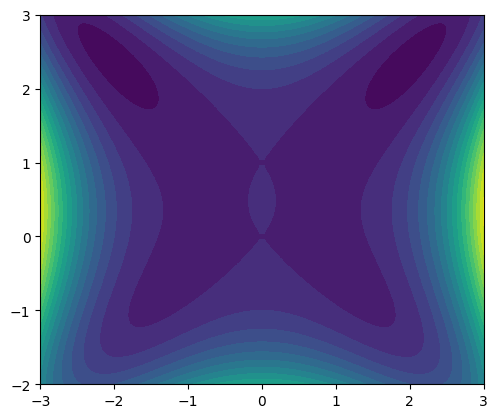

In [11]:
import json
dpi: float = 100
xlim = [-3, 3]
ylim = [-2, 3]

fig, ax = plt.subplots(dpi=dpi)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect("equal")

x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
z = x**4 - 1.5*x**2*y**2 + y**4 - 2*y**3 + y**2 + x**2*y - 2*x**2 # SPECIFIC

contourf_args: dict = {"levels": 20}
if "levels" in contourf_args and contourf_args["levels"] >= 0:
	ax.contourf(x, y, z, **contourf_args)

In [12]:
with open("output\Ex_Butterfly.json", "r") as f:
	saddle_data = json.load(f) # Load the data
saddleinfo = {"IDs": saddle_data["SaddleID"],
			  "coords": np.array(saddle_data["Position"])[:, :, 0],
			  "MIs": saddle_data["MorseIndex"],
			  "parentIDs": saddle_data["FatherSet"]}

with open("output\Ex_ButterflyDetail.json", "r") as f:
	traj_data = json.load(f) # Load the data
trajinfo = {"trajectories": [np.array(traj) for traj in traj_data["Path Positions"]],
			"times": [time for time in traj_data["Path Times"]],
			"startIDs": traj_data["Start ID"],
			"endIDs": traj_data["End ID"]}

ani = animateSL(fig, ax, saddleinfo, trajinfo, dt_per_frame=0.02)

We can export the animation to different file types.

In [13]:
ani.save("output\Ex_Butterfly.mp4", writer="ffmpeg") # Must install ffmpeg